# Тюнинг решающих деревьев. Практическая работа

## Цель практической работы

Научиться снижать переобучение дерева и увеличивать его предсказательную способность на реальных данных.

## Что нужно сделать

- Загрузить данные и ознакомиться с ними.
- Реализовать построение решающего дерева с помощью  библиотеки Scikit-learn.
- Подобрать гиперпараметры дерева.
- Поэкспериментировать со стрижкой (cost-complexity pruning) дерева.

## Как выполнить задание
- Обратите внимание, что задание не нужно сдавать на проверку
- Выполните все пункты задания и проверьте себя с ответами ниже
- Важно, чтобы модель получилась хорошего качества и не была переобучена.


Скачайте файл с заданием в материалах, откройте его через Jupyter Notebook и выполните задачи.

Пусть у нас имеется некоторый набор данных `sales.csv` – данные о продажах квартир.

- цена продажи (SalePrice) – зависимая переменная;
- наземная жилая зона (GrLivArea);
- общее качество (Overall Quality);
- территория гаража (GarageArea);
- условия сделки (SaleCondition).

Реализуйте построение модели решающего дерева на этих данных. Проверьте качество модели на обучающей и тестовой выборках с помощью R^2. Определите, что вы не переобучились.

## Загрузка и предобработка данных

В модуле 5 вы уже работали с этим набором данных, решали задачу при помощи линейной регрессии.

Повторим блок загрузки, предобработки и разделения данных на тренировочную и тестовую части из практики пятого модуля.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv('sales.csv')

In [3]:
data.head()

,SalePrice,GrLivArea,GarageArea,OverallQual,Street,SaleCondition
0,208500,1710,548,7,Pave,Normal
1,181500,1262,460,6,Pave,Normal
2,223500,1786,608,7,Pave,Normal
3,140000,1717,642,7,Pave,Abnorml
4,250000,2198,836,8,Pave,Normal


In [4]:
data['Street'] = pd.get_dummies(data['Street'], drop_first=True)
SaleCondition = pd.get_dummies(data['SaleCondition'], drop_first=True)
data = data.drop(['SaleCondition'], axis=1)
data = pd.concat([data, SaleCondition], axis=1)

In [5]:
data['part_garage'] = data['GarageArea']/data['GrLivArea']

In [6]:
x = ['GrLivArea', 'GarageArea', 'OverallQual', 'Street', 'AdjLand', 'Alloca',
       'Family', 'Normal', 'Partial', 'part_garage']
y = ['SalePrice']

In [7]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(data[x], data[y], train_size=0.7, random_state=123) # random_state нужен для воспроизводимости результата

Обучите решающее дерево с параметрами по умолчанию на тренировочных данных, затем оцените качество на тренировочных и тестовых данных.

Везде далее качество – это значении метрики $R^2$.

Сделайте выводы:
*  хорошая ли получилась модель (по качеству на тесте)?
*  переобучена ли модель?

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

tree = DecisionTreeRegressor()
tree.fit(Xtrain, ytrain)

pred_train = tree.predict(Xtrain)
pred_test = tree.predict(Xtest)

print('train score:', r2_score(ytrain, pred_train))
print('test score:', r2_score(ytest, pred_test))

train score: 0.9997875001371536
test score: 0.6314305756242802


### Ваши выводы тут

По качеству на тесте модель получилась недостаточно точной.
Также качество по обучающей выборке значительно превышает результат по тестовой, что свидетельствует о переобученности модели.

Теперь оцените качество модели (r2) на кросс-валидации с тремя фолдами.

Для кросс-валидации используйте все обучающие данные (до разбиения на трейн и тест).

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(tree, data[x], data[y], scoring='r2', cv=3).mean()

0.6034318604542125

Что вы можете сказать о качестве модели? Совпало ли среднее качество на кросс-валидацией со значением $R^2$ на тестовых данных? Почему?

### Ваши выводы тут

Среднее качество почти совпадает с результатом на тестовых данных.

Давайте улучшать модель.

Для начала подберите по кросс-валидации в цикле оптимальную глубину дерева:
*   кросс-валидацию делайте только по тренировочным данным (cv=3, scoring='r2')
*   глубину ищите в диапазоне от 1 до 20 включительно
*   выведите на экран значение max_depth, для которого значение метрики на кросс-валидации максимально

In [12]:
max_score = 0
best_depth = 0
for depth in range(1, 21):
    tree = DecisionTreeRegressor(max_depth=depth)
    score = cross_val_score(tree, Xtrain, ytrain, scoring='r2', cv=3).mean()  
    print(depth, score)
    if score > max_score:
        max_score = score
        best_depth = depth

print("best depth:", best_depth)

1 0.4730286732671081
2 0.5848595301105214
3 0.5704306628708652
4 0.6003506490149615
5 0.6085022267213066
6 0.6168711205453311
7 0.6020580557564191
8 0.5896192230606735
9 0.5929496366069847
10 0.5451925360876676
11 0.567309175575479
12 0.5702469368158427
13 0.5589200754520837
14 0.555413921508237
15 0.5260547222213194
16 0.5330495004484354
17 0.5455738622568173
18 0.558892011062215
19 0.543730867775642
20 0.5470074084900628
best depth: 6


Теперь для найденного значения max_depth обучите дерево на всех тренировочных данных, сделайте предсказание на трейне и на тесте и оцените значения метрики.

Удалось ли:
*  улучшить качество предсказания на тесте?
*  снизить переобучение?

In [13]:
tree = DecisionTreeRegressor(max_depth=best_depth)
tree.fit(Xtrain, ytrain)

pred_train = tree.predict(Xtrain)
pred_test = tree.predict(Xtest)

print('train score:', r2_score(ytrain, pred_train))
print('test score:', r2_score(ytest, pred_test))

train score: 0.8793304502214313
test score: 0.7507343979736868


### Ваши выводы тут

Переобучение удалось снизить, качество на тесте возросло.

Теперь для найденной оптимальной глубины дерева подберите значение min_samples_split в диапазоне от 1 до 15 с шагом 1. Также по кросс-валидации на тренировочных данных (как и при подборе max_depth).

In [19]:
max_score = 0
best_samples = 0
for samples in range(1, 16):
    tree = DecisionTreeRegressor(max_depth=best_depth, min_samples_split=samples)
    score = cross_val_score(tree, Xtrain, ytrain, scoring='r2', cv=3).mean()  
    print(samples, score)
    if score > max_score:
        max_score = score
        best_samples = samples

print("best samples:", best_samples)

1 nan
2 0.6111316667447574
3 0.6113672205149334
4 0.6169718828749137
5 0.6372583564714049
6 0.6383305864913441
7 0.631257732474256
8 0.6395297299856778
9 0.6366497818255764
10 0.6662545420807814
11 0.6573342712746711
12 0.6453179218114801
13 0.6435211068916656
14 0.6433222973757847
15 0.64397673704128
best samples: 10


Теперь для найденного значения max_depth и найденного min_samples_split обучите дерево на всех тренировочных данных, сделайте предсказание на трейне и на тесте и оцените значения метрики.

Удалось ли:
*  ещё улучшить качество предсказания на тесте?
*  ещё снизить переобучение?

In [20]:
tree = DecisionTreeRegressor(max_depth=best_depth, min_samples_split=best_samples)
tree.fit(Xtrain, ytrain)

pred_train = tree.predict(Xtrain)
pred_test = tree.predict(Xtest)

print('train score:', r2_score(ytrain, pred_train))
print('test score:', r2_score(ytest, pred_test))

train score: 0.874009469665285
test score: 0.7622744406802879


### Ваши выводы тут

Сейчас вы подбирали max_depth и min_samples_split последовательно, но, возможно, при одновременном подборе этих гиперпараметров оптимальный набор значений этих гиперпараметров получится другим.

При помощи вложенного цикла по той же схеме с кросс-валидацией на тренировочных данных подберите пару значений (max_depth, min_samples_split), для которых достигается наилучшее среднее значение метрики на кросс-валидации.

Выведите на экран найденные значения гиперпараметров.

In [24]:
max_score = 0
best_depth = 0
best_samples = 0
for depth in range(1, 21):
    for samples in range(2, 16):
        tree = DecisionTreeRegressor(max_depth=depth, min_samples_split=samples)
        score = cross_val_score(tree, Xtrain, ytrain, scoring='r2', cv=3).mean()  
        print('depth:', depth, 'samples:', samples, score)
        if score > max_score:
            max_score = score
            best_samples = samples
            best_depth = depth

print("best depth:", best_depth)
print("best samples:", best_samples)

depth: 1 samples: 2 0.4730286732671081
depth: 1 samples: 3 0.4730286732671081
depth: 1 samples: 4 0.4730286732671081
depth: 1 samples: 5 0.4730286732671081
depth: 1 samples: 6 0.4730286732671081
depth: 1 samples: 7 0.4730286732671081
depth: 1 samples: 8 0.4730286732671081
depth: 1 samples: 9 0.4730286732671081
depth: 1 samples: 10 0.4730286732671081
depth: 1 samples: 11 0.4730286732671081
depth: 1 samples: 12 0.4730286732671081
depth: 1 samples: 13 0.4730286732671081
depth: 1 samples: 14 0.4730286732671081
depth: 1 samples: 15 0.4730286732671081
depth: 2 samples: 2 0.5848595301105214
depth: 2 samples: 3 0.5848595301105214
depth: 2 samples: 4 0.5848595301105214
depth: 2 samples: 5 0.5848595301105214
depth: 2 samples: 6 0.5848595301105214
depth: 2 samples: 7 0.5848595301105214
depth: 2 samples: 8 0.5848595301105214
depth: 2 samples: 9 0.5848595301105214
depth: 2 samples: 10 0.5848595301105214
depth: 2 samples: 11 0.5848595301105214
depth: 2 samples: 12 0.5848595301105214
depth: 2 samples

depth: 15 samples: 13 0.6265091909164249
depth: 15 samples: 14 0.6268956568463231
depth: 15 samples: 15 0.6313842413012559
depth: 16 samples: 2 0.5562309710918037
depth: 16 samples: 3 0.5425139832874176
depth: 16 samples: 4 0.5720928827010411
depth: 16 samples: 5 0.5773304637922514
depth: 16 samples: 6 0.5790833251814402
depth: 16 samples: 7 0.6126544771694472
depth: 16 samples: 8 0.6250189815243222
depth: 16 samples: 9 0.6179444748158718
depth: 16 samples: 10 0.6313352181370995
depth: 16 samples: 11 0.6393178928487135
depth: 16 samples: 12 0.6274310911518725
depth: 16 samples: 13 0.6245319637192367
depth: 16 samples: 14 0.6281670111874036
depth: 16 samples: 15 0.6297969209353337
depth: 17 samples: 2 0.5442597322429149
depth: 17 samples: 3 0.5716143080541206
depth: 17 samples: 4 0.5487883373597372
depth: 17 samples: 5 0.5930114735895143
depth: 17 samples: 6 0.5991165185062782
depth: 17 samples: 7 0.601196526626658
depth: 17 samples: 8 0.6167469265509081
depth: 17 samples: 9 0.613377814

Теперь для найденного значения max_depth и найденного min_samples_split обучите дерево на всех тренировочных данных, сделайте предсказание на трейне и на тесте и оцените значения метрики.

*  Лучше ли подбирать гиперпараметры одновременно? Что можно сказать о качестве и переобученности алгоритма?

In [25]:
tree = DecisionTreeRegressor(max_depth=best_depth, min_samples_split=best_samples)
tree.fit(Xtrain, ytrain)

pred_train = tree.predict(Xtrain)
pred_test = tree.predict(Xtest)

print('train score:', r2_score(ytrain, pred_train))
print('test score:', r2_score(ytest, pred_test))

train score: 0.8304914297420238
test score: 0.7811238056960585


### Ваши выводы тут

При одновременном подборе гиперпараметров модель стала ещё менее переобучена.

А теперь попробуйте снизить переобучение не за счёт подбора различных гиперпараметров, ограничивающих структуру дерева, а за счёт стрижки.

По аналогии с тем, как было сделано в уроке про стрижку найдите список возможных значений $\alpha$ для стрижки, вычисляя их по тренировочным данным (нужна функция cost_complexity_pruning_path).

In [31]:
tree = DecisionTreeRegressor()
path = tree.cost_complexity_pruning_path(Xtrain, ytrain)
alphas = path['ccp_alphas']

Следуя ноутбуку из того же скринкаста про стрижку, для каждого из найденных значений $\alpha$ обучите решающее дерево на тренировочных данных, сделайте предсказания на трейне и тесте и вычислите метрику. 

Постройте графики ошибки на трейне и тесте в зависимости от значения $\alpha$, оба графика на одной координатной плоскости.

Также вычислите значение $\alpha$, для которого качество на тесте максимально. Выведите его на экран.

In [37]:
r2_train = []
r2_test = []
best_score = 0
best_alpha = alphas[0]

for alpha in alphas:
    tree = DecisionTreeRegressor(ccp_alpha = alpha)
    tree.fit(Xtrain, ytrain)

    pred_train = tree.predict(Xtrain)
    pred_test = tree.predict(Xtest)
    
    train_score = r2_score(ytrain, pred_train)
    test_score = r2_score(ytest, pred_test)
    
    r2_train.append(train_score)
    r2_test.append(test_score)    
    
    if test_score > best_score:
        best_score = test_score
        best_alpha = alpha
        
        
print('best score:', best_score)
print('best alpha:', best_alpha)

best score: 0.8007272709379292
best alpha: 16641136.63749563


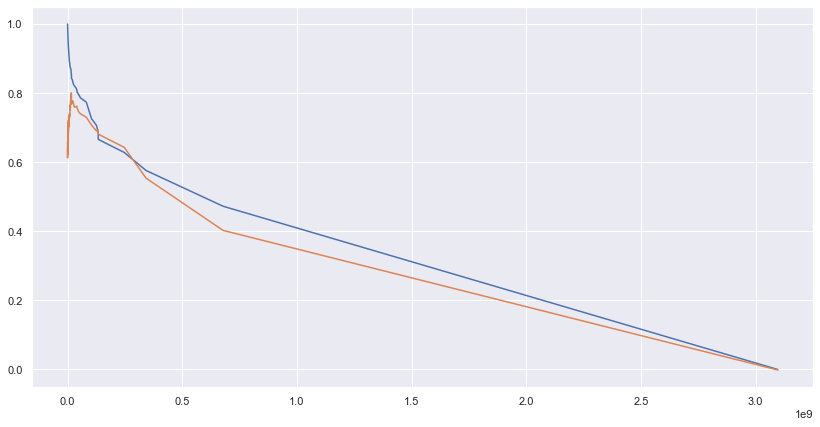

In [40]:
plt.figure(figsize=(14,7))
plt.plot(alphas, r2_train)
plt.plot(alphas, r2_test)

Для найденного значения $\alpha$ обучите дерево с параметром ccp_alpha равным $\alpha$ на тренировочных данных, сделайте предсказание на трейне и тесте и оцените качество предсказания на новых данных и переобучение модели.

Какая модель в итоге получилась лучше: с ограничением max_depth и min_samples_split или при помощи стрижки?

In [41]:
tree = DecisionTreeRegressor(ccp_alpha = best_alpha)
tree.fit(Xtrain, ytrain)

pred_train = tree.predict(Xtrain)
pred_test = tree.predict(Xtest)

print('train score:', r2_score(ytrain, pred_train))
print('test score:', r2_score(ytest, pred_test))

train score: 0.8556259974026101
test score: 0.794217022920247


### Ваши выводы тут

|

|

|

|

|

## Ответы для самопроверки

Обучите решающее дерево с параметрами по умолчанию на тренировочных данных, затем оцените качество на тренировочных и тестовых данных.

Везде далее качество – это значении метрики $R^2$.

Сделайте выводы:
*  хорошая ли получилась модель (по качеству на тесте)?
*  переобучена ли модель?

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()

tree.fit(Xtrain, ytrain)

pred_train = tree.predict(Xtrain)
pred_test = tree.predict(Xtest)

In [ ]:
from sklearn.metrics import r2_score

r2_score(ytrain, pred_train), r2_score(ytest, pred_test)

(0.9997875001371536, 0.621767874481379)

Дерево получилось сильно переобученным. Качество предсказания на новых данных невысокое.

Теперь оцените качество модели (r2) на кросс-валидации с тремя фолдами.

Для кросс-валидации используйте все обучающие данные (до разбиения на трейн и тест).

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(tree, data[x], data[y], cv=3, scoring='r2').mean()

0.5766292377175918

Что вы можете сказать о качестве модели? Совпало ли среднее качество на кросс-валидацией со значением $R^2$ на тестовых данных? Почему?

По кросс-валидации качество отличается от скора на тесте в силу того, что модель сильно привязана к разбиению на трейн-тест. Лучше оценивать среднее качество при нескольких разбиениях, то есть по кросс-валидации.

Давайте улучшать модель.

Для начала по кросс-валидации в цикле подберите оптимальную глубину дерева:
*   кросс-валидацию делайте только по тренировочным данным (cv=3, scoring='r2');
*   глубину ищите в диапазоне от 1 до 20 включительно;
*   выведите на экран значение max_depth, для которого значение метрики на кросс-валидации максимально.

In [ ]:
max_score = -1
depth = -1

for d in np.arange(1,21):
    tree = DecisionTreeRegressor(max_depth = d)

    score = cross_val_score(tree, Xtrain, ytrain, cv=3, scoring='r2').mean()
    print(d, score)

    if score > max_score:
        max_score = score
        depth = d

print(depth)

1 0.4730286732671081
2 0.5848595301105214
3 0.5704306628708652
4 0.5988254812315529
5 0.613141168470157
6 0.6142723013418843
7 0.5945088256234881
8 0.594931027780477
9 0.5962672634579836
10 0.5811833340079992
11 0.5492549954831768
12 0.5416982403574959
13 0.5360269331294188
14 0.5522864929770348
15 0.5413494374004723
16 0.5600645407892677
17 0.5497188578011336
18 0.5575258861753952
19 0.5415662488177513
20 0.5349656580181782
6


Теперь для найденного значения max_depth обучите дерево на всех тренировочных данных, сделайте предсказание на трейне и на тесте и оцените значения метрики.

Удалось ли:
*  улучшить качество предсказания на тесте?
*  снизить переобучение?

In [ ]:
tree2 = DecisionTreeRegressor(max_depth = depth)

tree2.fit(Xtrain, ytrain)

pred_train = tree2.predict(Xtrain)
pred_test = tree2.predict(Xtest)

In [ ]:
r2_score(ytrain, pred_train), r2_score(ytest, pred_test)

(0.8793304502214313, 0.7470043177837036)

Переобучение снизилось. Качество предсказания на новых данных подросло.

Теперь для найденной оптимальной глубины дерева подберите значение min_samples_split в диапазоне от 1 до 15 с шагом 1. Также по кросс-валидации на тренировочных данных (как и при подборе max_depth).

In [ ]:
max_score = -1
mss = -1

for m in np.arange(1,16):
    tree = DecisionTreeRegressor(max_depth = depth, min_samples_split = m)

    score = cross_val_score(tree, Xtrain, ytrain, cv=3, scoring='r2').mean()

    if score > max_score:
        max_score = score
        mss = m

print(mss)

10


Теперь для найденного значения max_depth и найденного min_samples_split обучите дерево на всех тренировочных данных, сделайте предсказание на трейне и на тесте и оцените значения метрики.

Удалось ли:
*  ещё улучшить качество предсказания на тесте?
*  ещё снизить переобучение?

In [ ]:
tree3 = DecisionTreeRegressor(max_depth = depth, min_samples_split = mss)

tree3.fit(Xtrain, ytrain)

pred_train = tree3.predict(Xtrain)
pred_test = tree3.predict(Xtest)

r2_score(ytrain, pred_train), r2_score(ytest, pred_test)

(0.874009469665285, 0.7622744406802879)

Переобучение снизилось ещё сильнее. Модель стала работать на новых данных ещё лучше.

Сейчас вы подбирали max_depth и min_samples_split последовательно, но, возможно, при одновременном подборе этих гиперпараметров оптимальный набор значений этих гиперпараметров получится другим.

При помощи вложенного цикла по той же схеме с кросс-валидацией на тренировочных данных подберите пару значений (max_depth, min_samples_split), для которых достигается наилучшее среднее значение метрики на кросс-валидации.

Выведите на экран найденные значения гиперпараметров.

In [ ]:
max_score = -1
depth = -1
mss = -1

for d in np.arange(1,21):
    for m in np.arange(1,16):
        tree = DecisionTreeRegressor(max_depth = d, min_samples_split = m)

        score = cross_val_score(tree, Xtrain, ytrain, cv=3, scoring='r2').mean()

        if score > max_score:
            max_score = score
            depth = d
            mss = m

print(depth, mss)

5 9


Теперь для найденного значения max_depth и найденного min_samples_split обучите дерево на всех тренировочных данных, сделайте предсказание на трейне и на тесте и оцените значения метрики.

*  Лучше ли подбирать гиперпараметры одновременно? Что можно сказать о качестве и переобученности алгоритма?

In [ ]:
tree4 = DecisionTreeRegressor(max_depth = depth, min_samples_split = mss)

tree4.fit(Xtrain, ytrain)

pred_train = tree4.predict(Xtrain)
pred_test = tree4.predict(Xtest)

r2_score(ytrain, pred_train), r2_score(ytest, pred_test)

(0.8304914297420238, 0.7811238056960585)

Одновременный подбор гиперпараметров точнее, чем поочередный. Это можно видеть по метрикам.

А теперь попробуйте снизить переобучение не за счёт подбора различных гиперпараметров, ограничивающих структуру дерева, а за счёт стрижки.

По аналогии с тем, как было сделано в уроке про стрижку, найдите список возможных значений $\alpha$ для стрижки, вычисляя их по тренировочным данным (нужна функция cost_complexity_pruning_path).

In [ ]:
tree = DecisionTreeRegressor()

path = tree.cost_complexity_pruning_path(Xtrain, ytrain)
alphas = path['ccp_alphas']

Следуя ноутбуку из того же скринкаста про стрижку, для каждого из найденных значений $\alpha$ обучите решающее дерево на тренировочных данных, сделайте предсказания на трейне и тесте и вычислите метрику. 

Постройте графики ошибки на трейне и тесте в зависимости от значения $\alpha$, оба графика на одной координатной плоскости.

Также вычислите значение $\alpha$, для которого качество на тесте максимально. Выведите его на экран.

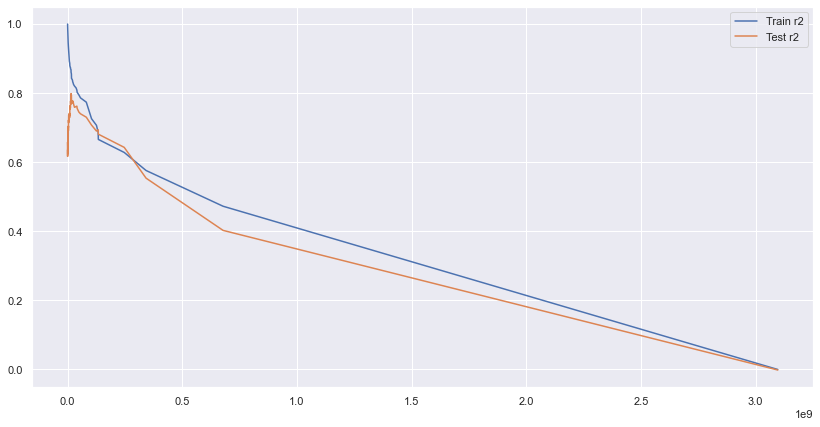

15142504.949450381


In [34]:
r2_train, r2_test=[], []

max_score = -1
alpha = -1

for i in alphas:
    tree = DecisionTreeRegressor(ccp_alpha = i)
    
    tree.fit(Xtrain, ytrain)
    ytrain_pred = tree.predict(Xtrain)
    ytest_pred = tree.predict(Xtest)
    
    r2_train.append(r2_score(ytrain, ytrain_pred))
    r2_test.append(r2_score(ytest, ytest_pred))

    if r2_score(ytest, ytest_pred) > max_score:
        max_score = r2_score(ytest, ytest_pred)
        alpha = i
    
    
sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y = r2_train, x = alphas, label = "Train r2")
sns.lineplot(y = r2_test, x = alphas, label = "Test r2")
plt.show()
print(alpha)

Для найденного значения $\alpha$ обучите дерево с параметром ccp_alpha равным $\alpha$ на тренировочных данных, сделайте предсказание на трейне и тесте и оцените качество предсказания на новых данных и переобучение модели.

Какая модель в итоге получилась лучше: с ограничением max_depth и min_samples_split или при помощи стрижки?

In [ ]:
tree5 = DecisionTreeRegressor(ccp_alpha = alpha)

tree5.fit(Xtrain, ytrain)

pred_train = tree5.predict(Xtrain)
pred_test = tree5.predict(Xtest)

r2_score(ytrain, pred_train), r2_score(ytest, pred_test)

(0.8605964058410931, 0.798560696099226)

Стрижка выдала наиболее качественную модель: она лучше всех предсказывает на новых данных и при этом слабо переобучена.